In [1]:
import cv2
import numpy as np

PATH = 'materials/'

def bresenham_circle(radius):
    points = []
    x = 0
    y = radius
    d = 3 - 2 * radius

    while y >= x:
        points.extend([(x, y), (y, x), (y, -x), (x, -y), (-x, -y), (-y, -x), (-y, x), (-x, y)])
        x += 1

        if d > 0:
            y -= 1
            d = d + 4 * (x - y) + 10
        else:
            d = d + 4 * x + 6

    return list(set(points))

def bresenham_circle_full(radius):
    points = []
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            if x**2 + y**2 <= radius**2:
                points.append((x, y))
    return points

def _fast_detector(patch, t=10):
    n = patch.shape[0] // 2
    Ic = patch[n, n]
    r_points = [(3,0), (3,1), (2,2), (1, 3), (0, 3), (-1, 3), (-2, 2), (-3, 1), (-3, 0), (-3, -1), (-2, -2), (-1, -3), (0, -3), (1, -3), (2, -2), (3, -1)]
    r_points = r_points + r_points[:8]
    n_straight_lower = 0
    n_straight_higher = 0

    for i in range(16):
        if patch[n + r_points[i][0], n + r_points[i][1]] > Ic + t:
            n_straight_higher += 1
            n_straight_lower = 0
        elif patch[n + r_points[i][0], n + r_points[i][1]] < Ic - t:
            n_straight_lower += 1
            n_straight_higher = 0
        else:
            n_straight_lower = 0
            n_straight_higher = 0

        if n_straight_higher >= 9 or n_straight_lower >= 9:
            return True

    return False

def compute_H(image, kernel_size=7, k=0.05):
    sobel_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=kernel_size)

    sobel_xx = sobel_x * sobel_x
    sobel_yy = sobel_y * sobel_y
    sobel_xy = sobel_x * sobel_y

    sobel_xx_gauss = cv2.GaussianBlur(sobel_xx, (kernel_size, kernel_size), 0)
    sobel_yy_gauss = cv2.GaussianBlur(sobel_yy, (kernel_size, kernel_size), 0)
    sobel_xy_gauss = cv2.GaussianBlur(sobel_xy, (kernel_size, kernel_size), 0)

    det = sobel_xx_gauss * sobel_yy_gauss - sobel_xy_gauss ** 2
    trace = sobel_xx_gauss + sobel_yy_gauss

    harris = det - k * trace ** 2
    harris = cv2.normalize(harris, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return harris

def non_maxima_suppression(image, points):
    best_points = []
    for y, x in points:
        max_point = image[y, x]
        patch = image[y-3:y+4, x-3:x+4]
        if max_point == np.max(patch):
            best_points.append((y, x))
    return best_points

def delete_redundant(points, Y, X):
    new_points = []
    for y, x in points:
        if 15 < y < Y-15 and 15 < x < X-15:
            new_points.append((y, x))
    return new_points

def intensity_centroid(image, points):
    r_points = bresenham_circle_full(15)
    C = []
    theta = []
    for y, x, _ in points:
        m00 = 0
        m10 = 0
        m01 = 0
        for j, i in r_points:
            m10 += x * image[y+j, x+i]
            m01 += y * image[y+j, x+i]
            m00 += image[y+j, x+i]
        if m00 != 0:
            C.append((m10//m00, m01//m00))
            theta.append(np.arctan2(m01, m10))
    return C, theta

def brief_descriptor(image, points, theta, size=15):
    descriptor = []

    pair_positions = open(f'{PATH}/orb_descriptor_positions.txt', 'r').read().split()
    pair_positions = np.float32(pair_positions).reshape(256, 2, 2)

    for (x, y), alfa in zip(points, theta):
        patch = image[y-size:y+size+1, x-size:x+size+1]
        patch = cv2.GaussianBlur(patch, (5, 5), 0)
        descriptor_vector = []
        for pair in pair_positions:
            x1, y1 = pair[0]
            x2, y2 = pair[1]
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)
            if 0 <= y1+size < patch.shape[0] and 0 <= x1+size < patch.shape[1] and 0 <= y2+size < patch.shape[0] and 0 <= x2+size < patch.shape[1]:
                if patch[y1+size, x1+size] < patch[y2+size, x2+size]:
                    descriptor_vector.append(1)
                else:
                    descriptor_vector.append(0)
        descriptor.append(descriptor_vector)
    
    return descriptor

def fast_detector(image, t=10, n=50):
    Y, X = image.shape[:2]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    harris_fast = np.zeros(image.shape)
    keypoints = []
    for y in range(3, Y-3):
        for x in range(3, X-3):
            patch = image[y-3:y+4, x-3:x+4]
            if _fast_detector(patch, t):
                keypoints.append((y, x))
    
    harris = compute_H(image)

    for y, x in keypoints:
        harris_fast[y, x] = harris[y, x]
    
    keypoints = non_maxima_suppression(harris_fast, keypoints)
    keypoints = delete_redundant(keypoints, Y, X)
    keypoints_with_harris = [(y, x, harris[y, x]) for y, x in keypoints]
    keypoints_with_harris.sort(key=lambda x: x[2], reverse=True)
    keypoints_with_harris = keypoints_with_harris[:n]

    C, theta = intensity_centroid(image, keypoints_with_harris)
    descriptor = brief_descriptor(image, C, theta)
    return C, descriptor, keypoints_with_harris, theta

In [2]:
PATH = 'materials/'
fountain1 = cv2.imread(f'{PATH}/fontanna1.jpg')
fountain2 = cv2.imread(f'{PATH}/fontanna2.jpg')

keypoints1, descriptors1, harris_points1, theta1 = fast_detector(fountain1)
keypoints2, descriptors2, harris_points2, theta2 = fast_detector(fountain2)

In [3]:
from materials import pm
def compare_points(desc1, desc2, center1, center2, image1, image2):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    distances = []

    for d1, c1 in zip(desc1, center1):
        lowest_dist = float('inf')
        for d2, c2 in zip(desc2, center2):
            new_dist = np.bitwise_xor(d1, d2).sum()
            if new_dist < lowest_dist:
                lowest_dist = new_dist
                best_match = c2
        distances.append(((c1[1], c1[0]), (best_match[1], best_match[0]), lowest_dist))
    d1 = distances.copy()
    distances.sort(key=lambda x: x[2])
    best_matches = [(x, y) for x, y, _ in distances[:100]]
    pm.plot_matches(image1, image2, best_matches)
    return d1

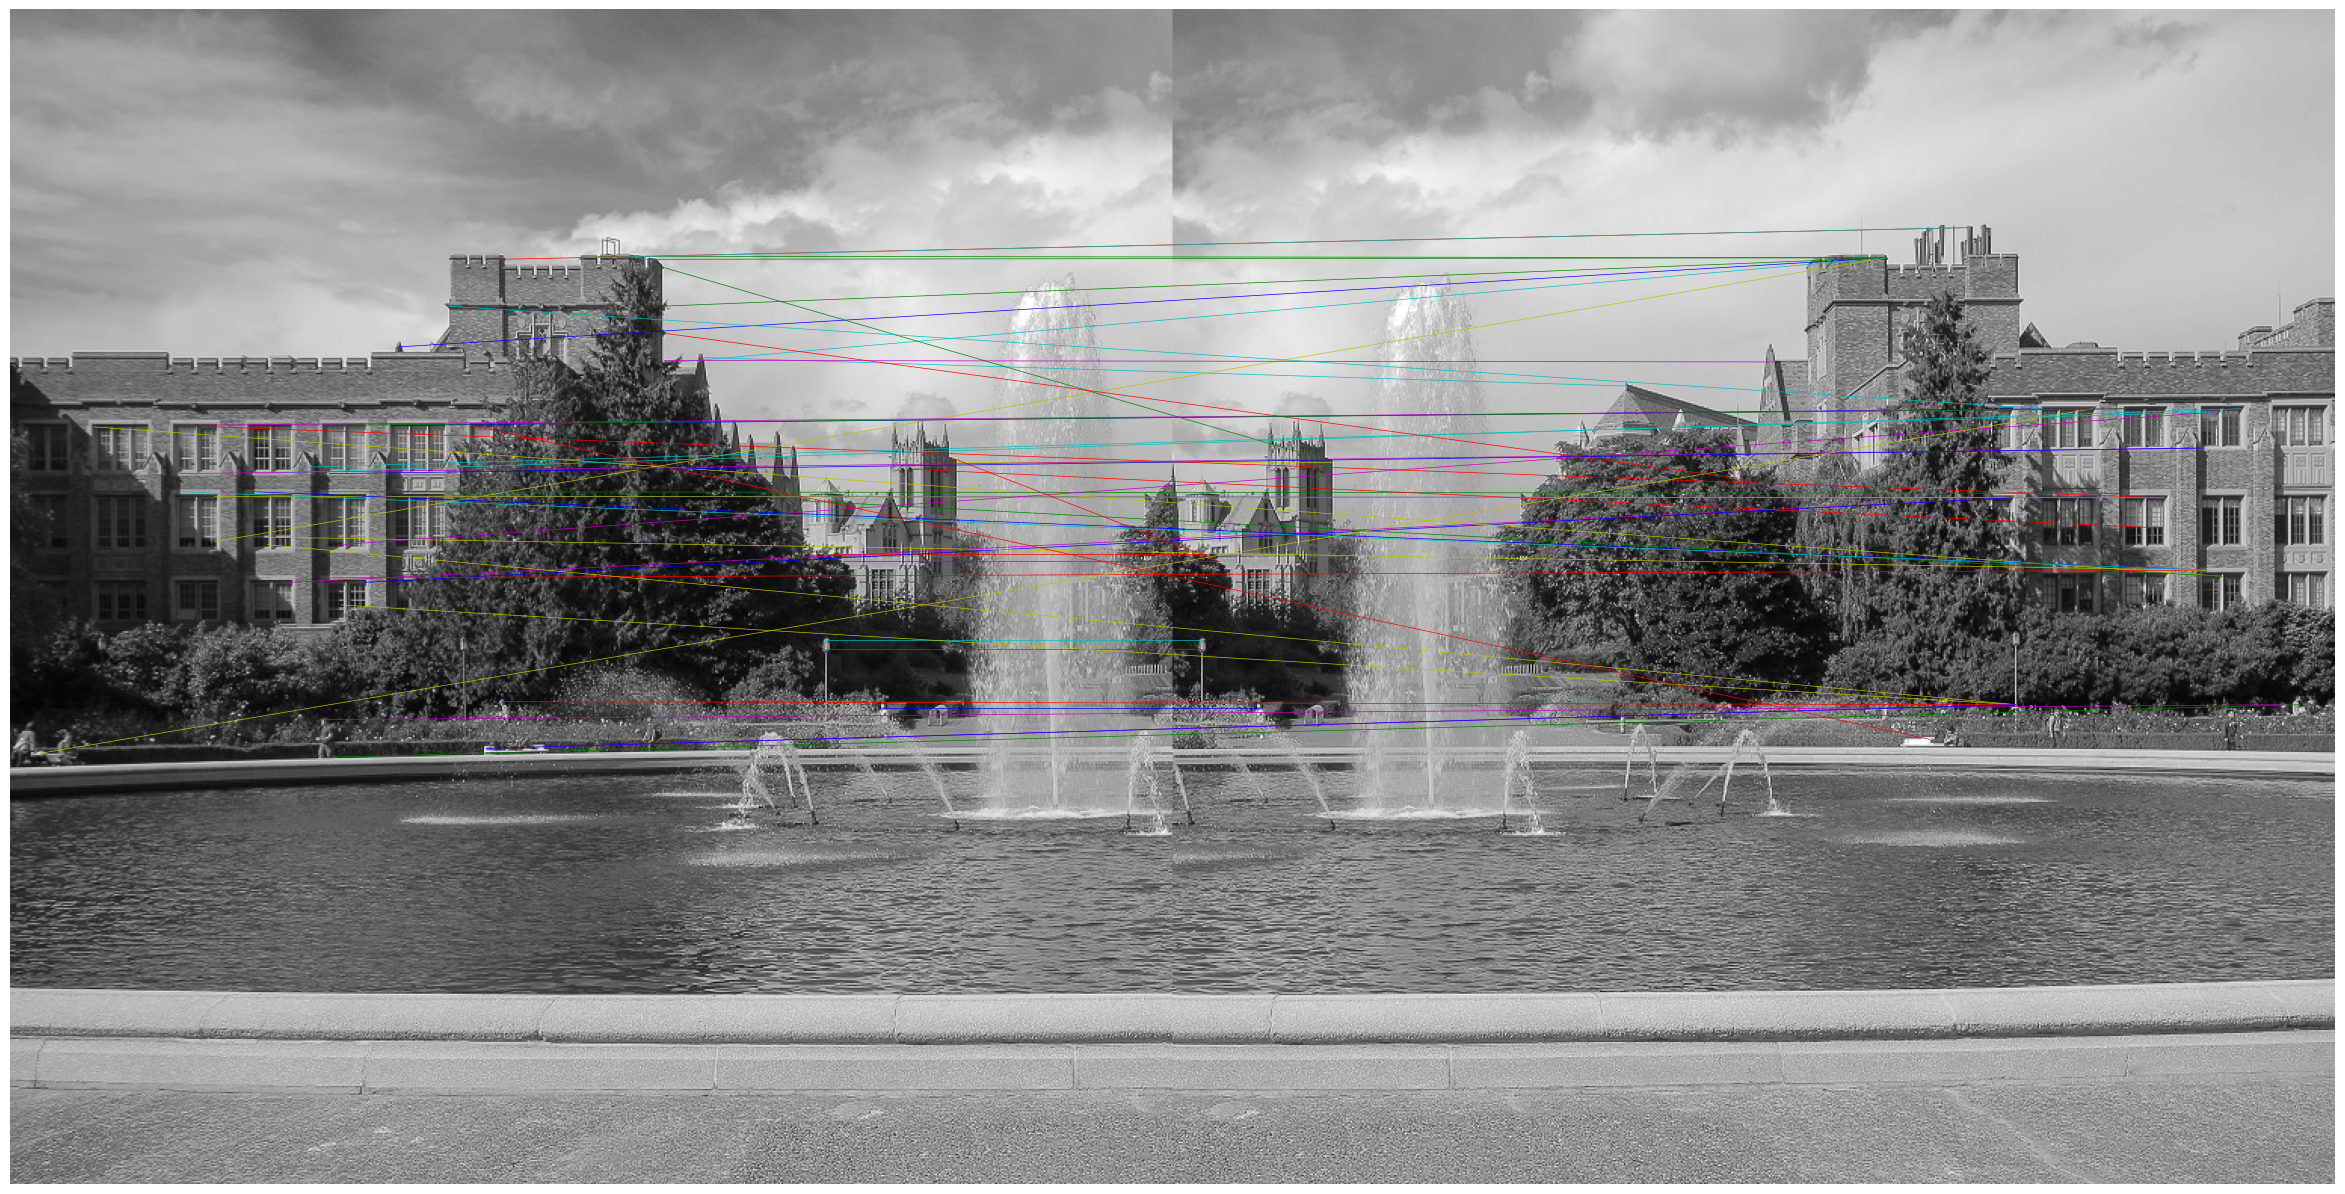

In [4]:
dist = compare_points(descriptors1, descriptors2, keypoints1, keypoints2, fountain1, fountain2)

In [5]:
def build_image_pyramid(image, levels=3):
    pyramid = [image]
    for _ in range(1, levels):
        downsampled = cv2.pyrDown(pyramid[-1])
        pyramid.append(downsampled)
    return pyramid

def fast_detector_with_pyramid(image, t=10, n=50, levels=3):
    pyramid = build_image_pyramid(image, levels)
    all_keypoints = []
    all_descriptors = []

    for level, img in enumerate(pyramid):
        scale = 2 ** level
        keypoints, descriptors, harris_points, theta = fast_detector(img, t, n)
        keypoints = [(int(y * scale), int(x * scale)) for (y, x) in keypoints]
        all_keypoints.extend(keypoints)
        all_descriptors.extend(descriptors)
    
    return all_keypoints, all_descriptors

In [6]:
keypoints1, descriptors1 = fast_detector_with_pyramid(fountain1)
keypoints2, descriptors2 = fast_detector_with_pyramid(fountain2)

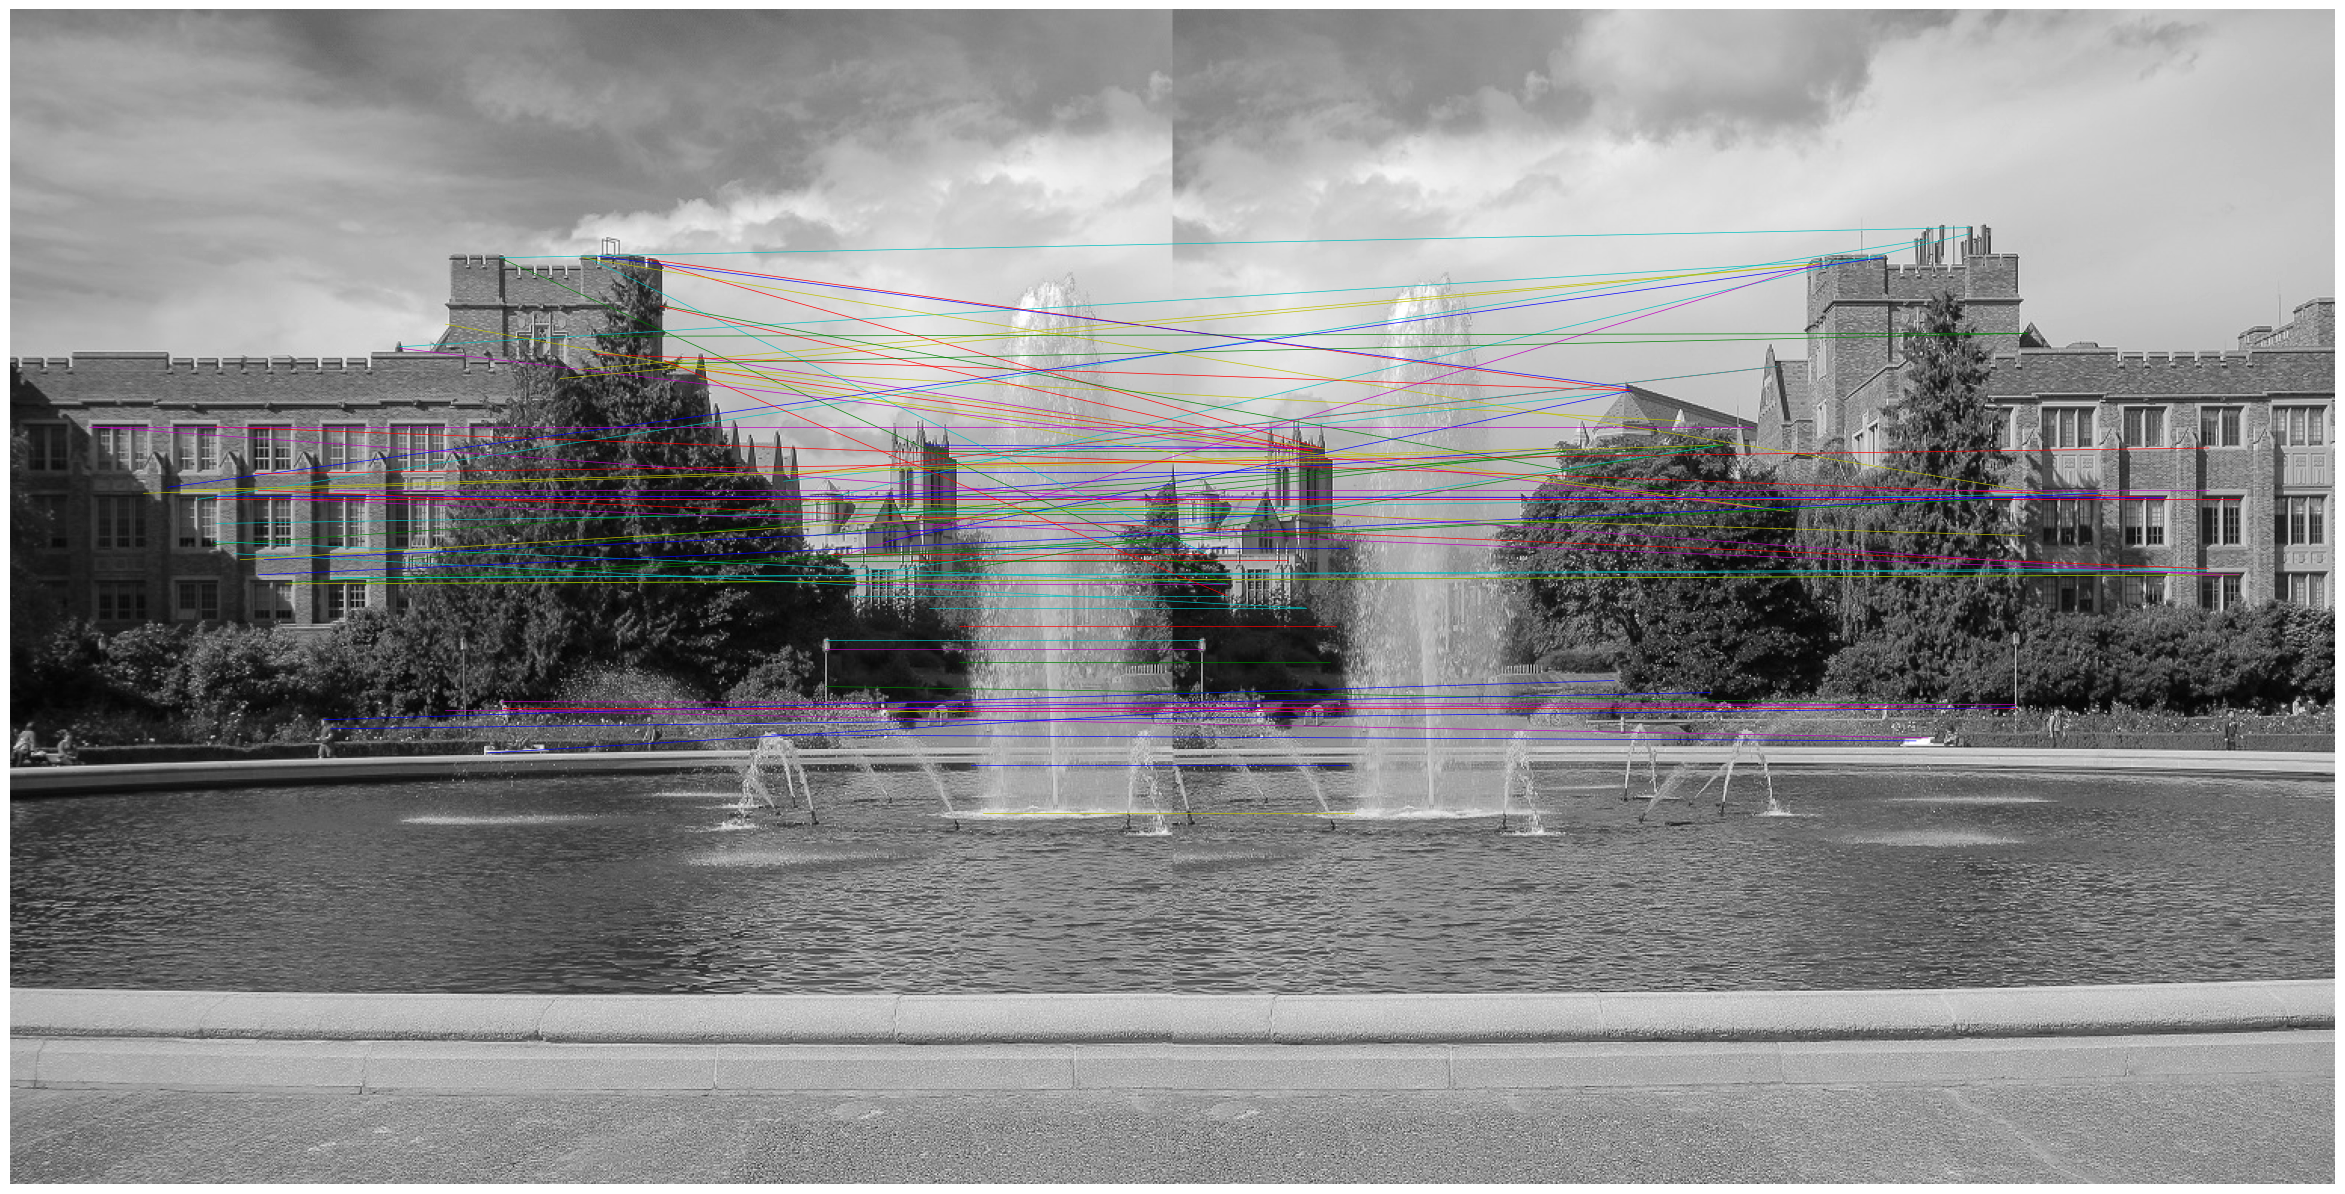

In [7]:
dist = compare_points(descriptors1, descriptors2, keypoints1, keypoints2, fountain1, fountain2)